In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy

In [3]:
# Data modeling
BASE = 'datasets/MINIFIGS/'
train_paths = pd.read_csv(BASE + 'index.csv')
test_paths = pd.read_csv(BASE + 'test.csv')

train_data = []
train_labels = np.array(train_paths['class_id'])-1

test_data = []
test_labels = np.array(test_paths['class_id'])-1

for path in train_paths['path']:
    img = cv2.imread(str(BASE + path))
    resized_img = cv2.resize(img,(224,224))
    train_data.append(resized_img)

for path in test_paths['path']:
    img = cv2.imread(str(BASE + path))
    resized_img = cv2.resize(img,(224,224))
    test_data.append(resized_img)

train_data = np.array(train_data)
test_data = np.array(test_data)

# Data Insight
print('Min: ',train_data.min(), ', Max: ', train_data.max())
print('Training Shape: ', train_data.shape, ', Labels: ', train_labels.shape)
# print('Validation Shape: ', val_data.shape, ', Labels: ', val_labels.shape)
print('Testing Shape: ', test_data.shape, ', Labels: ', test_labels.shape)

Min:  0 , Max:  255
Training Shape:  (371, 224, 224, 3) , Labels:  (371,)
Testing Shape:  (79, 224, 224, 3) , Labels:  (79,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


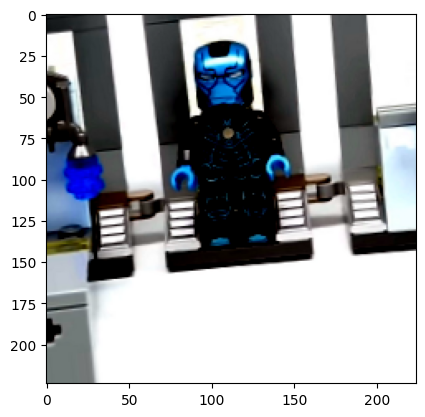

In [4]:
#Image Augmentation
input_preprocessor_mobilenetV2 = tf.keras.applications.mobilenet_v2.preprocess_input

imageAugmenter = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    # vertical_flip=True,
    preprocessing_function=input_preprocessor_mobilenetV2,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.1,
    fill_mode='nearest',
)

training_Augmenter = imageAugmenter.flow(train_data, train_labels, batch_size=10, shuffle=True, seed=12092003)

plt.imshow(next(training_Augmenter)[0][0])


In [5]:
# Actual Model
mobilenetV2 = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet')

base_input = mobilenetV2.input
base_output = mobilenetV2.layers[-2].output
# tf.keras.regularizers.l2(0.001)
output = tf.keras.layers.Dense(38,activation='softmax')(base_output)
model = tf.keras.Model(inputs = base_input,outputs = output)

for layer in model.layers[:-1]:
    layer.trainable = False

print(model.summary())
# tf.keras.utils.plot_model(mobilenetV2)

14536120/14536120 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                             

35363/35363 [==============================] - 0s 1us/step
Model -  pillow
Actual Image - 


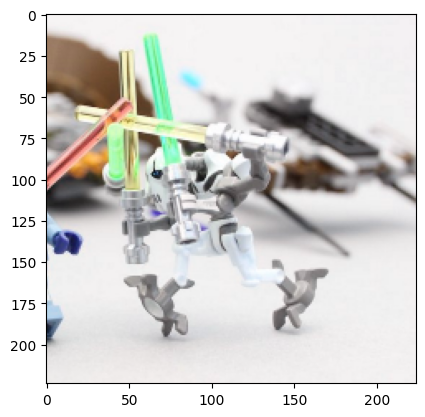

In [6]:
# MobilenetV2 predction without Training
image_number = 90
prediction = mobilenetV2.predict(train_data[image_number:image_number+1])
decoder = tf.keras.applications.mobilenet_v2.decode_predictions(prediction, top=1)
number, name, probability = decoder[0][0]
print("Model - ", name)
print("Actual Image - ")
plt.imshow(train_data[image_number])

In [7]:
#Model Compilation
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
metric = ['accuracy']

model.compile(optimizer=optim, loss=loss, metrics=metric)

In [8]:
#Model Training
epochs = 50

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=3,
    verbose=1, 
    restore_best_weights=True,
)

history = model.fit(
    training_Augmenter,
    epochs=epochs, 
    verbose=1,
    callbacks=[early_stopping],
)

Epoch 1/50
38/38 [==============================] - 25s 503ms/step - loss: 3.7153 - accuracy: 0.0755
Epoch 2/50
38/38 [==============================] - 25s 659ms/step - loss: 2.2129 - accuracy: 0.4097
Epoch 3/50
38/38 [==============================] - 25s 646ms/step - loss: 1.4075 - accuracy: 0.7197
Epoch 4/50
38/38 [==============================] - 19s 508ms/step - loss: 0.9565 - accuracy: 0.8329
Epoch 5/50
17/38 [============>.................] - ETA: 12s - loss: 0.7551 - accuracy: 0.8824

KeyboardInterrupt: 